
# Phân tích Bệnh Tim: Luật Kết hợp & Phân cụm
**Mục tiêu:** Phân tích tập dữ liệu `HeartDiseaseTrain-Test.csv` sử dụng thuật toán Apriori để tìm luật kết hợp và K-Means để phân cụm.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')


## 1. Tải Dữ liệu

In [2]:

file_path = 'HeartDiseaseTrain-Test.csv'
df = pd.read_csv(file_path)
print("Kích thước tập dữ liệu:", df.shape)
df.head()


Kích thước tập dữ liệu: (1025, 14)


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


## 2. Khai phá Luật Kết hợp (Apriori)


Thuật toán Apriori yêu cầu dữ liệu dạng phân loại (categorical). Chúng ta sẽ:
1. Phân nhóm (Binning) các biến số (Tuổi, Huyết áp, Cholesterol, v.v.) thành các khoảng (Thấp, Trung bình, Cao).
2. Chuyển đổi tất cả các cột sang định dạng chuỗi 'Thuộc tính=Giá trị'.


In [3]:

# Tạo bản sao cho Apriori
df_apriori = df.copy()

# Hàm hỗ trợ phân nhóm
def bin_feature(series, bins, labels):
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# 1. Tuổi (Age)
df_apriori['age_group'] = pd.cut(df_apriori['age'], bins=[20, 40, 55, 70, 90], labels=['Thanh niên', 'Trung niên', 'Cao niên', 'Người già'])

# 2. Huyết áp khi nghỉ (Resting Blood Pressure) (<120: Bình thường, 120-139: Tiền cao huyết áp, >=140: Cao huyết áp)
df_apriori['bp_group'] = pd.cut(df_apriori['resting_blood_pressure'], bins=[0, 120, 140, 200], labels=['Bình thường', 'Tiền cao huyết áp', 'Cao huyết áp'])

# 3. Cholesterol (<200: Tốt, 200-239: Ranh giới, >=240: Cao)
df_apriori['chol_group'] = pd.cut(df_apriori['cholestoral'], bins=[0, 200, 240, 600], labels=['Tốt', 'Ranh giới', 'Cao'])

# 4. Nhịp tim tối đa (Max Heart Rate) - Chia thành 3 nhóm theo phân vị
df_apriori['max_hr_group'] = pd.qcut(df_apriori['Max_heart_rate'], q=3, labels=['Thấp', 'Trung bình', 'Cao'])

# Xóa các cột số gốc
drop_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak', 'vessels_colored_by_flourosopy']
df_apriori.drop(columns=[c for c in drop_cols if c in df_apriori.columns], inplace=True)

# Chuyển đổi tất cả sang định dạng "Cột=Giá trị"
df_str = pd.DataFrame()
for col in df_apriori.columns:
    df_str[col] = df_apriori[col].astype(str).apply(lambda x: f"{col}={x}")

df_str.head()


,sex,chest_pain_type,fasting_blood_sugar,rest_ecg,exercise_induced_angina,slope,thalassemia,target,age_group,bp_group,chol_group,max_hr_group
0,sex=Male,chest_pain_type=Typical angina,fasting_blood_sugar=Lower than 120 mg/ml,rest_ecg=ST-T wave abnormality,exercise_induced_angina=No,slope=Downsloping,thalassemia=Reversable Defect,target=0,age_group=Trung niên,bp_group=Tiền cao huyết áp,chol_group=Ranh giới,max_hr_group=Cao
1,sex=Male,chest_pain_type=Typical angina,fasting_blood_sugar=Greater than 120 mg/ml,rest_ecg=Normal,exercise_induced_angina=Yes,slope=Upsloping,thalassemia=Reversable Defect,target=0,age_group=Trung niên,bp_group=Tiền cao huyết áp,chol_group=Ranh giới,max_hr_group=Trung bình
2,sex=Male,chest_pain_type=Typical angina,fasting_blood_sugar=Lower than 120 mg/ml,rest_ecg=ST-T wave abnormality,exercise_induced_angina=Yes,slope=Upsloping,thalassemia=Reversable Defect,target=0,age_group=Cao niên,bp_group=Cao huyết áp,chol_group=Tốt,max_hr_group=Thấp
3,sex=Male,chest_pain_type=Typical angina,fasting_blood_sugar=Lower than 120 mg/ml,rest_ecg=ST-T wave abnormality,exercise_induced_angina=No,slope=Downsloping,thalassemia=Reversable Defect,target=0,age_group=Cao niên,bp_group=Cao huyết áp,chol_group=Ranh giới,max_hr_group=Trung bình
4,sex=Female,chest_pain_type=Typical angina,fasting_blood_sugar=Greater than 120 mg/ml,rest_ecg=ST-T wave abnormality,exercise_induced_angina=No,slope=Flat,thalassemia=Fixed Defect,target=0,age_group=Cao niên,bp_group=Tiền cao huyết áp,chol_group=Cao,max_hr_group=Thấp


### One-Hot Encoding cho Apriori

In [4]:

# Tạo dummy variables
basket = pd.get_dummies(df_str, prefix='', prefix_sep='')
print(f"Tổng số giao dịch: {basket.shape[0]}")
print(f"Tổng số mục (items): {basket.shape[1]}")


Tổng số giao dịch: 1025
Tổng số mục (items): 35


### Áp dụng Apriori & Trích xuất Luật

In [5]:

# Tìm các tập phổ biến (Frequent Itemsets)
# Support là tỷ lệ giao dịch chứa tập itemset đó.
min_support = 0.2
frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)


,support,itemsets
4,0.850732,(fasting_blood_sugar=Lower than 120 mg/ml)
1,0.695610,(sex=Male)
7,0.663415,(exercise_induced_angina=No)
30,0.587317,"(sex=Male, fasting_blood_sugar=Lower than 120 ..."
67,0.572683,"(fasting_blood_sugar=Lower than 120 mg/ml, exe..."
11,0.530732,(thalassemia=Fixed Defect)
14,0.513171,(target=1)
6,0.500488,(rest_ecg=ST-T wave abnormality)
20,0.490732,(chol_group=Cao)
15,0.486829,(age_group=Cao niên)


In [6]:

# Sinh luật kết hợp
# Metric có thể là confidence hoặc lift.
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules.sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
389,(exercise_induced_angina=Yes),"(target=0, chest_pain_type=Typical angina)",0.336585,0.365854,0.246829,0.733333,2.004444,1.0,0.123688,2.378049,0.755348,0.541756,0.579487,0.704000
388,"(target=0, chest_pain_type=Typical angina)",(exercise_induced_angina=Yes),0.365854,0.336585,0.246829,0.674667,2.004444,1.0,0.123688,2.039184,0.790210,0.541756,0.509608,0.704000
844,"(exercise_induced_angina=Yes, fasting_blood_su...","(target=0, chest_pain_type=Typical angina)",0.278049,0.365854,0.200976,0.722807,1.975673,1.0,0.099250,2.287743,0.684040,0.453744,0.562888,0.636070
847,"(target=0, chest_pain_type=Typical angina)","(exercise_induced_angina=Yes, fasting_blood_su...",0.365854,0.278049,0.200976,0.549333,1.975673,1.0,0.099250,1.601963,0.778753,0.453744,0.375766,0.636070
849,(exercise_induced_angina=Yes),"(target=0, fasting_blood_sugar=Lower than 120 ...",0.336585,0.304390,0.200976,0.597101,1.961631,1.0,0.098522,1.726513,0.738935,0.456763,0.420798,0.628679
842,"(target=0, fasting_blood_sugar=Lower than 120 ...",(exercise_induced_angina=Yes),0.304390,0.336585,0.200976,0.660256,1.961631,1.0,0.098522,1.952692,0.704735,0.456763,0.487887,0.628679
851,(chest_pain_type=Typical angina),"(exercise_induced_angina=Yes, fasting_blood_su...",0.484878,0.214634,0.200976,0.414487,1.931132,1.0,0.096904,1.341329,0.936029,0.403131,0.254471,0.675425
840,"(exercise_induced_angina=Yes, fasting_blood_su...",(chest_pain_type=Typical angina),0.214634,0.484878,0.200976,0.936364,1.931132,1.0,0.096904,8.094774,0.613942,0.403131,0.876463,0.675425
1065,"(thalassemia=Fixed Defect, rest_ecg=ST-T wave ...","(target=1, fasting_blood_sugar=Lower than 120 ...",0.275122,0.380488,0.200000,0.726950,1.910575,1.0,0.095319,2.268863,0.657486,0.438972,0.559251,0.626296
1052,"(target=1, fasting_blood_sugar=Lower than 120 ...","(thalassemia=Fixed Defect, rest_ecg=ST-T wave ...",0.380488,0.275122,0.200000,0.525641,1.910575,1.0,0.095319,1.528121,0.769311,0.438972,0.345602,0.626296



**Giải thích:** 
Lift cao (>1) chỉ ra mối quan hệ tích cực mạnh mẽ. Confidence cho biết khả năng xảy ra của kết quả (consequent) khi biết nguyên nhân (antecedent).


## 3. Phân tích Phân cụm (Clustering - K-Means)


Chúng ta sẽ sử dụng dữ liệu số gốc và dữ liệu phân loại đã mã hóa để phân cụm.
1. Mã hóa (Encode) các biến phân loại.
2. Chuẩn hóa (Scale) các biến số.
3. Áp dụng K-Means.


In [7]:

# Tải lại/Reset dữ liệu
df_cluster = df.copy()

# Xử lý cột 'vessels_colored_by_flourosopy' (Từ chữ sang số)
vessels_map = {'Zero': 0, 'One': 1, 'Two': 2, 'Three': 3, 'Four': 4}
# Map nếu có, nếu không khớp (NaN) thì fill 0 hoặc xử lý sau. Ở đây giả sử dữ liệu chuẩn hoặc map phần lớn.
df_cluster['vessels_colored_by_flourosopy'] = df_cluster['vessels_colored_by_flourosopy'].map(vessels_map).fillna(0)


# Danh sách cột
cat_cols = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'slope', 'thalassemia']
num_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak', 'vessels_colored_by_flourosopy']

# One-Hot Encode cho biến phân loại
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_cats = pd.DataFrame(encoder.fit_transform(df_cluster[cat_cols]))
encoded_cats.columns = encoder.get_feature_names_out(cat_cols)

# Scale cho biến số
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_cluster[num_cols]), columns=num_cols)


# Kết hợp lại
X_clustering = pd.concat([scaled_nums, encoded_cats], axis=1)
X_clustering.head()


,age,resting_blood_pressure,cholestoral,Max_heart_rate,oldpeak,vessels_colored_by_flourosopy,sex_Male,chest_pain_type_Atypical angina,chest_pain_type_Non-anginal pain,chest_pain_type_Typical angina,fasting_blood_sugar_Lower than 120 mg/ml,rest_ecg_Normal,rest_ecg_ST-T wave abnormality,exercise_induced_angina_Yes,slope_Flat,slope_Upsloping,thalassemia_No,thalassemia_Normal,thalassemia_Reversable Defect
0,-0.268437,-0.377636,-0.659332,0.821321,-0.060888,1.209221,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.158157,0.479107,-0.833861,0.255968,1.727137,-0.731971,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.716595,0.764688,-1.396233,-1.048692,1.301417,-0.731971,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.724079,0.936037,-0.833861,0.516900,-0.912329,0.238625,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.834359,0.364875,0.930822,-1.874977,0.705408,2.179817,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


### Xác định K tối ưu (Phương pháp Elbow)

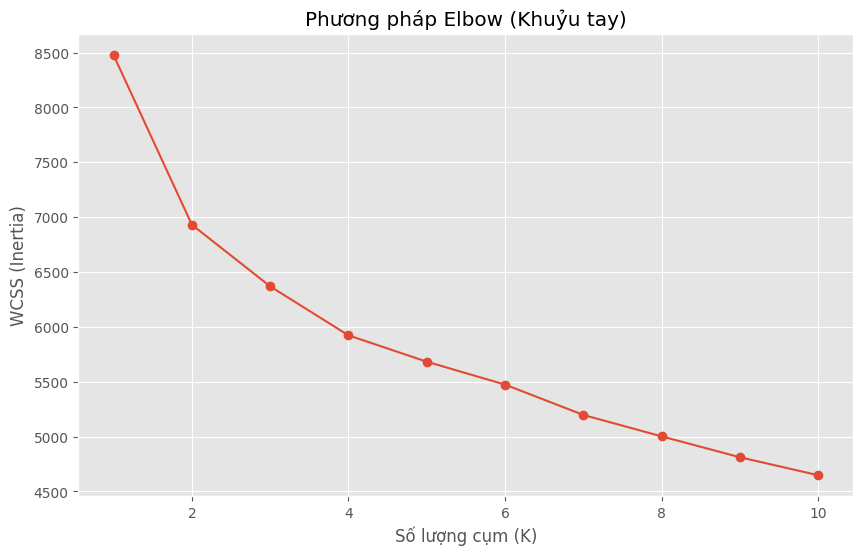

In [8]:

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_clustering)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(K_range, wcss, marker='o')
plt.title('Phương pháp Elbow (Khuỷu tay)')
plt.xlabel('Số lượng cụm (K)')
plt.ylabel('WCSS (Inertia)')
plt.show()


### Áp dụng K-Means với K tối ưu

In [9]:

# Giả sử K=3 là lựa chọn hợp lý dựa trên biểu đồ hoặc các nhóm rủi ro khác biệt.
# Bạn có thể điều chỉnh K dựa trên biểu đồ trên.
optimal_k = 3 
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
clusters = kmeans_final.fit_predict(X_clustering)

# Thêm nhãn cụm vào dataframe gốc
df['Cluster'] = clusters
print(df['Cluster'].value_counts())


Cluster
1    488
2    326
0    211
Name: count, dtype: int64


### Đánh giá & Trực quan hóa Cụm

In [10]:

# Silhouette Score
score = silhouette_score(X_clustering, clusters)
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.161


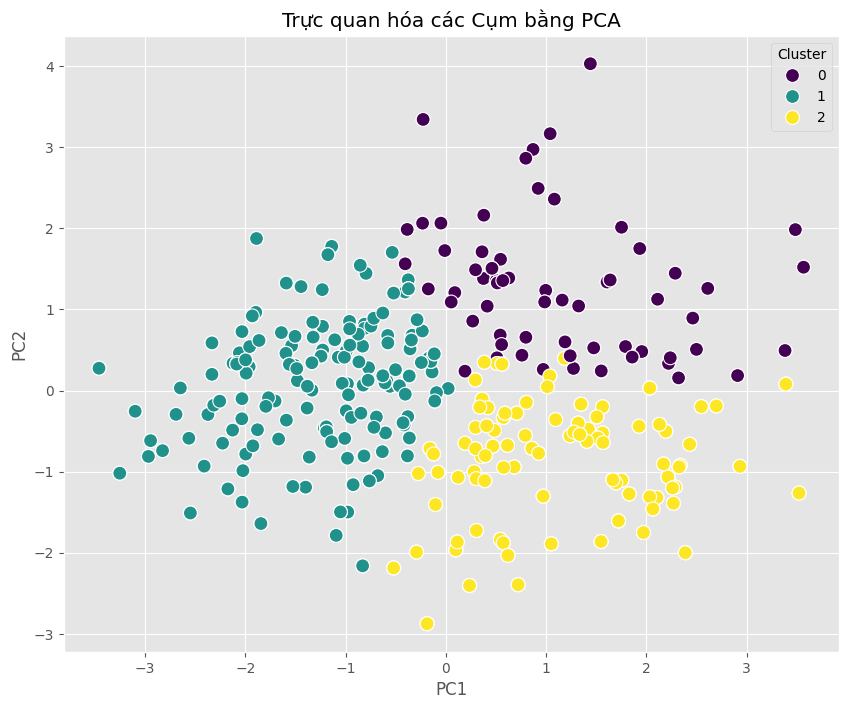

In [11]:

# PCA để trực quan hóa 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='viridis', s=100)
plt.title('Trực quan hóa các Cụm bằng PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()



### Hồ sơ Cụm (Cluster Profiling)
Xem giá trị trung bình của các đặc trưng số cho mỗi cụm để hiểu đặc điểm của chúng.


In [12]:

# Chuyển đổi vessels sang số để tính trung bình
vessels_map = {'Zero': 0, 'One': 1, 'Two': 2, 'Three': 3, 'Four': 4}
df['vessels_colored_by_flourosopy'] = df['vessels_colored_by_flourosopy'].map(vessels_map).fillna(0)

profile_num = df.groupby('Cluster')[num_cols].mean()
display(profile_num)

# Kiểm tra phân phối biến mục tiêu (target) trong các cụm
full_profile = df.groupby('Cluster')['target'].value_counts(normalize=True).unstack()
display(full_profile)


,age,resting_blood_pressure,cholestoral,Max_heart_rate,oldpeak,vessels_colored_by_flourosopy
Cluster,,,,,,
0,61.165877,151.113744,295.298578,147.431280,1.272038,1.000000
1,48.668033,126.473361,233.344262,163.965164,0.460656,0.338115
2,58.708589,126.680982,233.036810,127.972393,1.856135,1.217791


target,0,1
Cluster,,
0,0.644550,0.355450
1,0.219262,0.780738
2,0.785276,0.214724
